# Importing Required Libraries

In [2]:
import keras
from keras.datasets import cifar10
import numpy as np 
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score
import pickle
!pip install opencv-contrib-python==3.4.2.17
import cv2
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

Using TensorFlow backend.


# Our Functions To Load The CIFAR10 Dataset


In [0]:
def load_cfar10_train(path, batch_id):
    with open(path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

def load_cfar10_test(path):
    with open(path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [0]:
# print("Loading Training Dataset.")
# images_train = []
# labels_train = []

# for i in range(1,6):
#     features_part_train, labels_part_train = load_cfar10_train("../CIFAR10", i)
#     images_train.extend(features_part_train)
#     labels_train.extend(labels_part_train)
#     print("Loaded batch", i)

# images_train = np.array(images_train)
# labels_train = np.array(labels_train)

# Using keras.datasets To Load CIFAR10 Dataset

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
images_train = x_train
labels_train = y_train
images_test = x_test
labels_test = y_test

# Plotting Images 

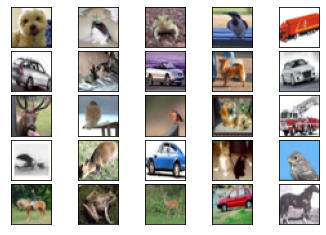

In [6]:
side = 5
frame, sub_image = plt.subplots(side, side)
for m in range(side):
    for n in range(side):
        idx = np.random.randint(0, images_train.shape[0])
        sub_image[m, n].imshow(images_train[idx])
        sub_image[m, n].get_xaxis().set_visible(False)
        sub_image[m, n].get_yaxis().set_visible(False)
frame.subplots_adjust(hspace=0.1)
frame.subplots_adjust(wspace=0)
plt.show()

# Pre-Processing Images

In [0]:
def cvtToGray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray, (150, 150), interpolation=cv2.INTER_AREA) 
    return resized_image


# Functions To Generate SIFT Descriptors

In [0]:
def extractSIFTIndividual(image):
    sift = cv2.xfeatures2d.SIFT_create()
    _, desc = sift.detectAndCompute(image,None)
    return desc

def extractSIFTFeatures(image_list, iLabels):
    length = len(image_list)
    count = 0

    featuresBeforeClustering = []
    unconcatenatedDescriptors = []
    labels = []  
    for image in image_list:
        progress_percent = (count/length)*100
        print ("count =", count)
        print ("Length =", length)
        print('SIFT Extraction Progress: %6.2f%%'%(progress_percent),end='\r')
        
        image = cvtToGray(image)
        desc = extractSIFTIndividual(image)

        if desc is not None:
            unconcatenatedDescriptors.append(desc)
            labels.append(iLabels[count])
        count += 1
    featuresBeforeClustering = np.concatenate(unconcatenatedDescriptors, axis=0)
    print ('SIFT extraction done!')
    
    return featuresBeforeClustering, unconcatenatedDescriptors, labels

# Function To Generate KMeans Model

In [0]:
def kMeans(features):
    print("KMeans clustering begins.")

    result = MiniBatchKMeans(init='k-means++', n_clusters=64,max_iter=1000, batch_size=1000, n_init=10, max_no_improvement=10, verbose=0).fit(features)

    print("KMeans clustering ends.")
    return result

# Function To Aggreagate Descriptors And Form Histograms

In [0]:
def aggregateDescriptors(descriptorsSIFT, model):
    histogram = []
    length = len(descriptorsSIFT)

    for i in range(length):
        predictedLabels = model.predict(descriptorsSIFT[i])
        hist, _ = np.histogram(predictedLabels, bins = 10)
        histogram.append(hist)

    histogram = np.asarray(histogram)
    histogram = np.array(histogram)

    return histogram

# Functions To Generate VLAD Descriptors

In [0]:
def genVLADIndividual(image, k_means_model):
    
    predictedLabels = k_means_model.predict(image)
    clusterCenters = k_means_model.cluster_centers_
    numClusters = k_means_model.n_clusters
    
    r,d = image.shape
    result = np.zeros([numClusters,d])
    
    for i in range(numClusters):
        progress_percent = (i/numClusters)*100
        
        # If there is atleast one descriptor for the current predicted label, it's difference with the corresponding cluster center is taken
        if (np.sum(predictedLabels == i) > 0):
            result[i] = np.sum(image[predictedLabels == i, :] - clusterCenters[i], axis=0)
    result = result.flatten()

    # Power normalization
    
    result = np.sign(result)*np.sqrt(np.abs(result))

    # L2 normalization

    result = result/np.sqrt(np.dot(result,result))
    return result

def genVLADFeatures(images, iLabels, model):
    descriptors = []
    labels = []
    length = len(images)
    
    count = 0
    for image in images:
        progress_percent = (count/length)*100
        print('VLAD Generation Progress: %6.2f%%'%(progress_percent))
        
        image = cvtToGray(image)
        des = extractSIFTIndividual(image)
        
        if des is not None:
            vDes = genVLADIndividual(des, model)
            descriptors.append(vDes)
            labels.append(iLabels[count])
        count += 1
            
    descriptors = np.asarray(descriptors)
    return descriptors,labels

# BoVW Approach

## Generating SIFT Features

In [0]:
features,unconcatenated_descriptors,labels = extractSIFTFeatures(images_train, labels_train)

In [0]:
features_test,unconcatenated_descriptors_test,labels_test_hist = extractSIFTFeatures(images_test, labels_test)

## Generating KMeans Model

In [14]:
model_mini_kmeans = kMeans(features)

KMeans clustering begins.
KMeans clustering ends.


## Forming Histograms

In [0]:
X_train_hist = aggregateDescriptors(unconcatenated_descriptors, model_mini_kmeans)
X_test_hist = aggregateDescriptors(unconcatenated_descriptors_test, model_mini_kmeans)

## Performing PCA

In [0]:
sc = StandardScaler() 
pca = PCA(n_components = 0.9) 

X_train = sc.fit_transform(X_train_hist) 
X_test = sc.transform(X_test_hist) 
X_train = pca.fit_transform(X_train_hist) 
X_test = pca.transform(X_test_hist)

## Training, Making Predictions And Obtaining Accuracy Score

In [0]:
model = svm.LinearSVC(multi_class='ovr')
model.fit(X_train_hist,labels)

Y_pred = model.predict(X_test_hist)
acc = accuracy_score(labels_test_hist, Y_pred)
print (acc)

# VLAD Approach

## Generating VLADs

In [0]:
VLAD_features, VLAD_labels = genVLADFeatures(images_train,labels_train, model_mini_kmeans)

In [0]:
VLAD_features_test, VLAD_labels_test = genVLADFeatures(images_test, labels_test,model_mini_kmeans)

In [0]:
X_train = VLAD_features
Y_train = VLAD_labels

X_test = VLAD_features_test
Y_test = VLAD_labels_test

## Performing PCA

In [0]:
sc = StandardScaler() 
pca = PCA(n_components = 0.9) 

X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test)

## Training, Making Predictions And Obtaining Accuracy Score

In [0]:
model = svm.LinearSVC(multi_class='ovr')
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print (acc)